/tmp/ipykernel_51824/3037926329.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=coeffs, palette='magma')


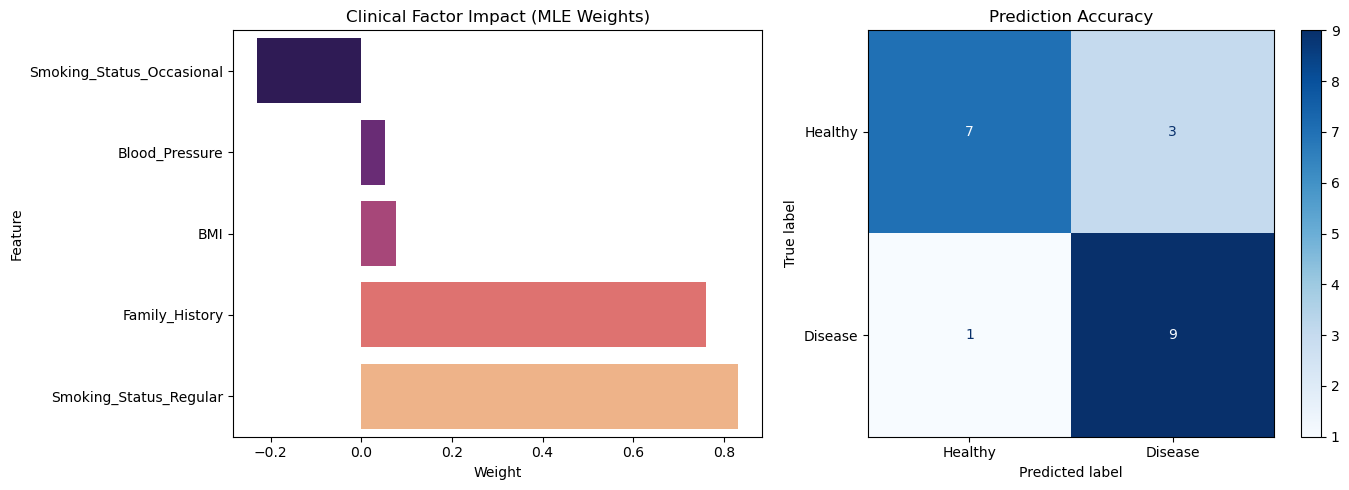

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

# 1. GENERATE SYNTHETIC CLINICAL DATASET
n_samples = 100
data = {
    'Blood_Pressure': np.random.randint(110, 180, n_samples),
    'BMI': np.random.uniform(18, 40, n_samples),
    'Smoking_Status': np.random.choice(['Non-smoker', 'Occasional', 'Regular'], n_samples),
    'Family_History': np.random.choice([0, 1], n_samples)
}

# Create a realistic relationship for the Target (Disease: 1, Healthy: 0)
logit = (0.05 * (data['Blood_Pressure'] - 120) + 0.1 * (data['BMI'] - 25) + 
         0.8 * data['Family_History'] + 
         np.where(data['Smoking_Status'] == 'Regular', 1.5, 0) - 2)
prob = 1 / (1 + np.exp(-logit))
data['Has_Disease'] = np.random.binomial(1, prob)

df = pd.DataFrame(data)

# Introduce Missing Entries (10% missing for BP and BMI)
df.loc[df.sample(frac=0.1).index, 'Blood_Pressure'] = np.nan
df.loc[df.sample(frac=0.1).index, 'BMI'] = np.nan
df.to_csv('medical_data_raw.csv', index=False)

# 2. PREPROCESSING PIPELINE
# A. Numerical Imputation: Filling missing BP and BMI with the Mean
num_imputer = SimpleImputer(strategy='mean')
df[['Blood_Pressure', 'BMI']] = num_imputer.fit_transform(df[['Blood_Pressure', 'BMI']])

# B. One-Hot Encoding: Converting Smoking Status to binary columns
# We drop 'Non-smoker' to act as the baseline (reference category)
encoder = OneHotEncoder(drop='first', sparse_output=False)
smoking_encoded = encoder.fit_transform(df[['Smoking_Status']])
smoking_cols = encoder.get_feature_names_out(['Smoking_Status'])
smoking_df = pd.DataFrame(smoking_encoded, columns=smoking_cols)

# Combine processed data
df_final = pd.concat([df.drop('Smoking_Status', axis=1), smoking_df], axis=1)

# 3. TRAINING USING MLE
X = df_final.drop('Has_Disease', axis=1)
y = df_final['Has_Disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LogisticRegression uses MLE (Maximum Likelihood Estimation) to find best weights
model = LogisticRegression()
model.fit(X_train, y_train)
joblib.dump(model, 'medical_model.pkl')

# 4. VISUALIZATION
plt.figure(figsize=(14, 5))

# Plot coefficients (Feature Importance)
plt.subplot(1, 2, 1)
coeffs = pd.DataFrame({'Feature': X.columns, 'Weight': model.coef_[0]}).sort_values(by='Weight')
sns.barplot(x='Weight', y='Feature', data=coeffs, palette='magma')
plt.title('Clinical Factor Impact (MLE Weights)')

# Plot Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, model.predict(X_test))
ConfusionMatrixDisplay(cm, display_labels=['Healthy', 'Disease']).plot(ax=plt.gca(), cmap='Blues')
plt.title('Prediction Accuracy')

plt.tight_layout()
plt.show()